# Poetry Generation: Experiment Report

This notebook loads aggregated batch experiment results and the runner summary, plots comparison charts (mean ± 95% CI when available), and displays sample poems for the best method. Paths assume `outputs/experiments/batch/aggregated_multi.json` and `outputs/experiments/examples_<Method>.txt`.

In [1]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

batch_dir = Path('../outputs/experiments/batch')
single_dir = Path('../outputs/experiments')

agg_file = batch_dir / 'aggregated_multi.json'
summary_file = single_dir / 'summary.json'

if agg_file.exists():
    with open(agg_file, 'r', encoding='utf-8') as f:
        agg = json.load(f).get('summary', {})
    df = pd.DataFrame([{'method': k, **v} for k, v in agg.items()])
    print('Loaded aggregated_multi.json from', agg_file)
else:
    # fallback to single-run results
    res_file = single_dir / 'results.json'
    if res_file.exists():
        with open(res_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        rows = []
        for r in data.get('runs', []):
            m = r['metrics']
            rows.append({'method': r.get('config'), 'avg_reward': m.get('avg_reward'), 'perplexity': m.get('perplexity'), 'distinct_2': m.get('distinct_2'), 'distinct_3': m.get('distinct_3')})
        df = pd.DataFrame(rows)
    else:
        df = pd.DataFrame()

df

Loaded aggregated_multi.json from ../outputs/experiments/batch/aggregated_multi.json


,method,mean_reward,std_reward,n,ci95_reward,mean_perplexity,std_perplexity,mean_distinct_2,mean_distinct_3
0,Base,-0.110062,0.044320,6,0.035464,47.654546,28.901489,0.974232,0.998801
1,Hybrid,-0.109836,0.044286,6,0.035436,57.710643,50.224827,0.972879,0.990246
2,PPLM,-0.110016,0.044215,6,0.035379,37.611651,27.257365,0.972835,0.993310
3,RLHF,-0.110090,0.043970,6,0.035183,41.542684,29.820891,0.970448,0.992172


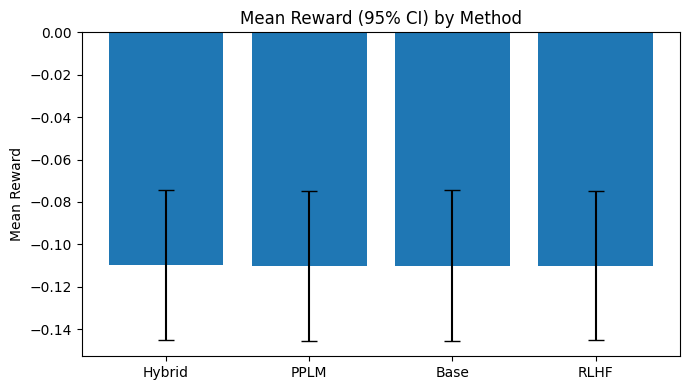

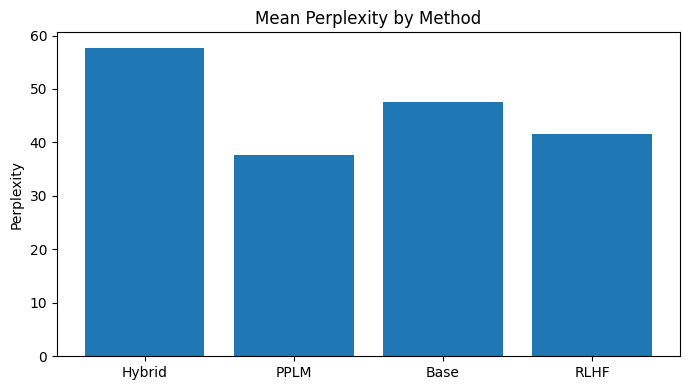

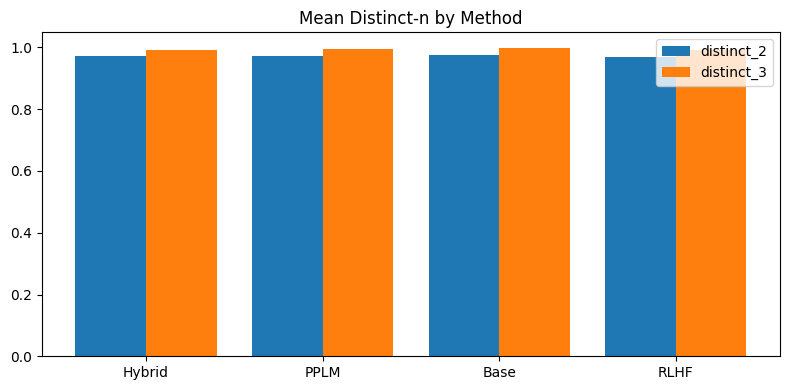

In [2]:
# Plot results with error bars if available
if not df.empty:
    if 'mean_reward' in df.columns:
        df_plot = df.sort_values('mean_reward', ascending=False)
        plt.figure(figsize=(7,4))
        plt.bar(df_plot['method'], df_plot['mean_reward'], yerr=df_plot['ci95_reward'], capsize=6)
        plt.title('Mean Reward (95% CI) by Method')
        plt.ylabel('Mean Reward')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(7,4))
        plt.bar(df_plot['method'], df_plot['mean_perplexity'])
        plt.title('Mean Perplexity by Method')
        plt.ylabel('Perplexity')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,4))
        x = range(len(df_plot))
        plt.bar([p - 0.2 for p in x], df_plot['mean_distinct_2'], width=0.4, label='distinct_2')
        plt.bar([p + 0.2 for p in x], df_plot['mean_distinct_3'], width=0.4, label='distinct_3')
        plt.xticks(x, df_plot['method'])
        plt.legend()
        plt.title('Mean Distinct-n by Method')
        plt.tight_layout()
        plt.show()
    else:
        df.plot(x='method', y=['avg_reward','perplexity'], kind='bar', subplots=True, figsize=(10,6))
        plt.tight_layout()
        plt.show()
else:
    print('No results available')

In [3]:
# Show best method and sample poems
best = None
if summary_file.exists():
    with open(summary_file, 'r', encoding='utf-8') as f:
        s = json.load(f)
    best = s.get('best_method')
    print('Runner summary best method:', best)
elif not df.empty and 'method' in df.columns:
    # choose by mean_reward if present else avg_reward
    if 'mean_reward' in df.columns:
        best = df.sort_values('mean_reward', ascending=False)['method'].iloc[0]
    else:
        best = df.sort_values('avg_reward', ascending=False)['method'].iloc[0]
    print('Best method from summary table:', best)

if best is not None:
    ex_file = Path('../outputs/experiments') / f'examples_{best}.txt'
    if ex_file.exists():
        print('Showing first 3 examples for', best, '\n')
        with open(ex_file, 'r', encoding='utf-8') as ef:
            text = ef.read()
        poems = text.split('\n' + '-'*80 + '\n')
        for i, p in enumerate(poems[:3]):
            print(f'---- Example {i+1} ----')
            print(p.strip())
            print('\n')
    else:
        print('No example file found for', best)
else:
    print('No best method identified')

Runner summary best method: Hybrid
Showing first 3 examples for Hybrid 

---- Example 1 ----
Kind Reader! take your choice to cry or laugh; Here HAROLD lies, but where's his Epitaph? If such you seek, try Westminster, and view Ten thousand just as fit for him as you. Athens, Hyrm, Ticorns, Poets, Librarians. Othas, Pools! For the Lord loves those who may


---- Example 2 ----
'Dr. Birch's young friends will reassemble to-day, Feb. 1st.' White is the wold, and ghostly The dank and leafless trees; And 'M's and 'N's are mostly Pronounced like 'B's and 'D's: 'Neath bleak sheds, ice-encrusted, The sheep stands, mute and stolid: And ducks find out, disgusted, That all the ponds are solid. Many a stout steer's work is (At least in this world) finished; The gross amount of turkies Is sensibly diminished: The holly-boughs are faded, The painted crackers gone; Would I could write, as Gray did, An Elegy thereon! For Christmas-time is ended: Now is 'our youth' regaining Those sweet spots where are